<a href="https://colab.research.google.com/github/Method-for-Software-System-Development/Cloud_Computing/blob/tirgul-Noa-Tal/tirgul6/tirgul6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests beautifulsoup4
!pip install firebase

In [ ]:
DBLink = "ENTER YOUR DB LINK HERE"

In [3]:
url = 'https://en.wikipedia.org/wiki/Formula_One'

{'car': 219, 'race': 340, 'driver': 209, 'rule': 24, 'fia': 89, 'senna': 9, 'monaco': 20, 'wing': 9, 'ferrari': 44, 'schumach': 18, 'alonso': 5}
1.0


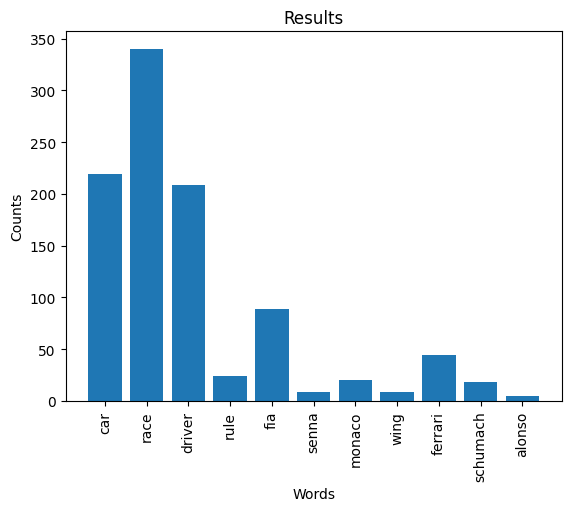

In [4]:
import requests
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from firebase import firebase
import matplotlib.pyplot as plt


def fetch_page(url):
 response = requests.get(url)
 if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  return soup
 else:
  return None

def index_words(soup):
  index = {}
  words = re.findall(r'\w+', soup.get_text())
  for word in words:
    word = word.lower()
    if word in index:
      index[word] += 1
    else:
      index[word] = 1
  return index

def remove_stop_words(index):
  stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at'}
  for stop_word in stop_words:
    if stop_word in index:
      del index[stop_word]
  return index

def apply_stemming(index):
  stemmer = PorterStemmer()
  stemmed_index = {}
  for word, count in index.items():
    stemmed_word = stemmer.stem(word)
    if stemmed_word in stemmed_index:
      stemmed_index[stemmed_word] += count
    else:
      stemmed_index[stemmed_word] = count
  return stemmed_index

def search(query, index):
  stemmer = PorterStemmer()
  query_words = re.findall(r'\w+', query.lower())
  results = {}
  for word in query_words:
    word = stemmer.stem(word)
    if word in index:
      results[word] = index[word]
  return results
def search_engine(url, query):
  soup = fetch_page(url)
  if soup is None:
     return None
  index = index_words(soup)
  index = remove_stop_words(index)
  index = apply_stemming(index)
  results = search(query, index)
  return results

queries = 'car racing driver rules FIA senna monaco wing ferrari Schumacher Alonso'
FBconn = firebase.FirebaseApplication(DBLink,None)
results = search_engine(url, queries)
print(results)

#add the results dictionary to the FB database
FBconn.put('/','found_words_from_query',results)
rank=1
for word, count in results.items():
  rank = rank*1/count
rank = 1-rank
print(rank)

# create a bar chart showing the number of appearences of each of the 10 words with set spacing between the words to make it readable
words = list(results.keys())
counts = list(results.values())
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Results')
plt.show()